In [1]:
import pandas as pd
df = pd.read_csv("../Data/aggregated_spice_price_data_2019_2024.csv")
df

,Price Date,Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal)
0,2019-10-31,8476.100000,9156.250000,8854.900000
1,2019-11-01,8362.619048,10080.666667,9385.238095
2,2019-11-02,8228.023256,9744.162791,9147.720930
3,2019-11-03,8620.000000,8881.111111,8768.888889
4,2019-11-04,8185.625000,9976.950000,9199.375000
...,...,...,...,...
1822,2024-10-26,9873.513514,11910.000000,11096.297297
1823,2024-10-27,10366.666667,10916.666667,10635.166667
1824,2024-10-28,10333.593750,11987.500000,11361.281250
1825,2024-10-29,9893.684211,11420.263158,10820.263158


In [2]:
df = df[["Price Date", "Modal Price (Rs./Quintal)"]]
df.loc[:, 'Price Date'] = pd.to_datetime(df['Price Date'])
df.set_index('Price Date', inplace=True)
index_dtype = df.index.dtype
print(f"Datatype of the index: {index_dtype}")

Datatype of the index: datetime64[ns]


/Users/tejas/PycharmProjects/Spice_Price_Forecast/.venv/lib/python3.12/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [3]:
import seaborn as sns
color_pal = sns.color_palette()

<Axes: title={'center': 'Modal Price'}, xlabel='Price Date'>

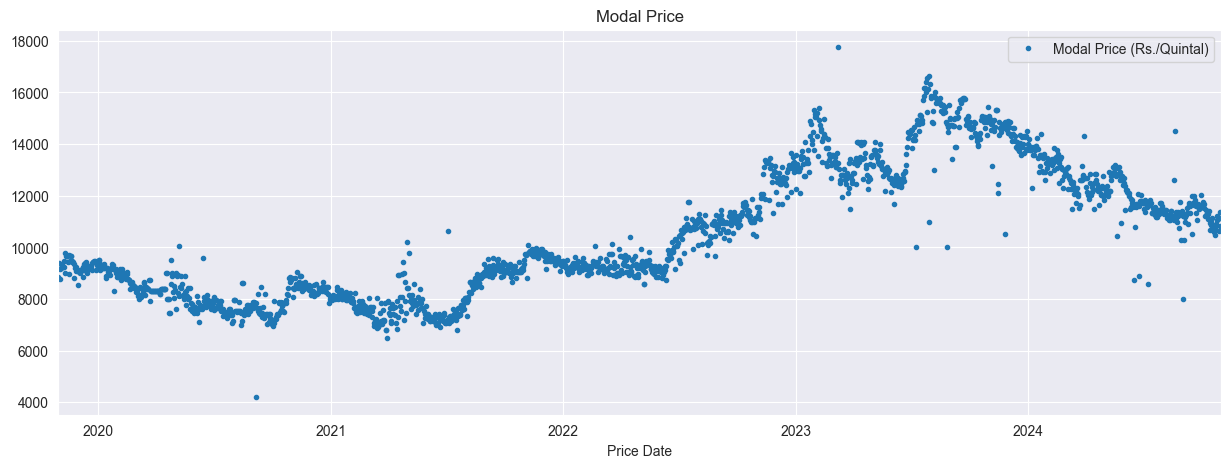

In [4]:
df.plot(style='.', figsize=(15, 5), color=color_pal[0], title="Modal Price", )

In [5]:
train_df = df.iloc[df.index<'01-01-2024']
test_df = df.iloc[df.index>='01-01-2024']

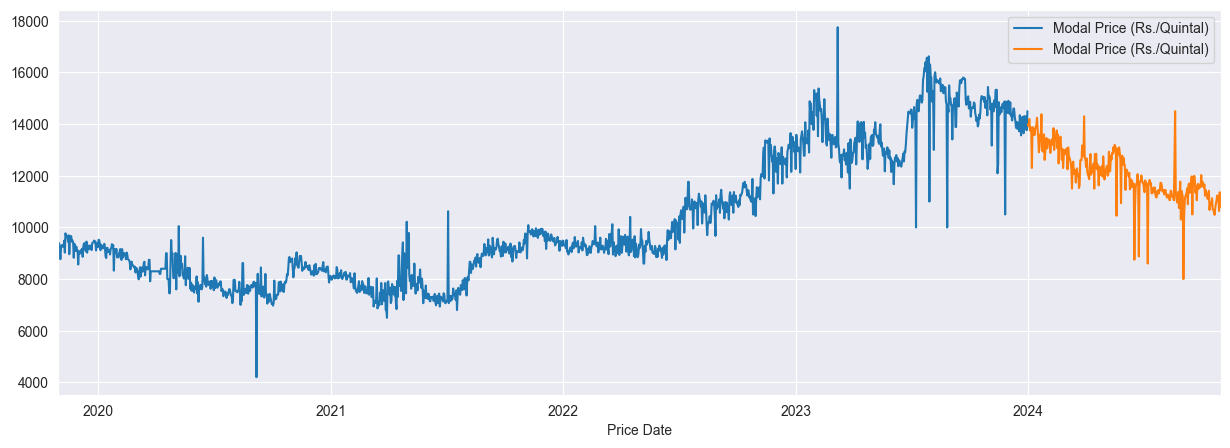

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 5))
train_df.plot(ax=ax, label='Training set')
test_df.plot(ax=ax, label='Test set')
plt.show()


In [7]:
import pandas as pd

target_map = df['Modal Price (Rs./Quintal)'].to_dict()

def create_features(df):
    """
    Create time series features based on time series index for weekly forecasting.
    """
    df = df.copy()

    # Time-based features
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week

    # Lag features
    df['lag_1'] = (df.index - pd.Timedelta('1 days')).map(target_map)
    df['lag7'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag30'] = (df.index - pd.Timedelta('30 days')).map(target_map)
    df['lag90'] = (df.index - pd.Timedelta('90 days')).map(target_map)
    df['lag364'] = (df.index - pd.Timedelta('364 days')).map(target_map)

    # Rolling window features
    for window in [1, 7, 30, 90, 364]:
        df[f'rolling_mean_{window}'] = df['Modal Price (Rs./Quintal)'].rolling(window=window, min_periods=1).mean()
        df[f'rolling_median_{window}'] = df['Modal Price (Rs./Quintal)'].rolling(window=window, min_periods=1).median()
        df[f'rolling_std_{window}'] = df['Modal Price (Rs./Quintal)'].rolling(window=window, min_periods=1).std()

    # Exponential moving averages
    df['ema7'] = df['Modal Price (Rs./Quintal)'].ewm(span=7, adjust=False).mean()
    df['ema30'] = df['Modal Price (Rs./Quintal)'].ewm(span=30, adjust=False).mean()
    df['ema90'] = df['Modal Price (Rs./Quintal)'].ewm(span=90, adjust=False).mean()

    # Moving averages
    df['moving_avg_7'] = df['Modal Price (Rs./Quintal)'].rolling(window=7, min_periods=1).mean()
    df['moving_avg_30'] = df['Modal Price (Rs./Quintal)'].rolling(window=30, min_periods=1).mean()

    # Other statistical features
    df['max_30'] = df['Modal Price (Rs./Quintal)'].rolling(window=30, min_periods=1).max()
    df['min_30'] = df['Modal Price (Rs./Quintal)'].rolling(window=30, min_periods=1).min()
    df['range_30'] = df['max_30'] - df['min_30']

    return df


In [8]:
df = create_features(df)
df

,Modal Price (Rs./Quintal),dayofweek,quarter,month,year,dayofyear,weekofyear,lag_1,lag7,lag30,...,rolling_median_364,rolling_std_364,ema7,ema30,ema90,moving_avg_7,moving_avg_30,max_30,min_30,range_30
Price Date,,,,,,,,,,,,,,,,,,,,,
2019-10-31,8854.900000,3,4,10,2019,304,44,NaN,NaN,NaN,...,8854.900000,NaN,8854.900000,8854.900000,8854.900000,8854.900000,8854.900000,8854.900000,8854.900000,0.000000
2019-11-01,9385.238095,4,4,11,2019,305,44,8854.900000,NaN,NaN,...,9120.069048,375.005663,8987.484524,8889.115361,8866.555782,9120.069048,9120.069048,9385.238095,8854.900000,530.338095
2019-11-02,9147.720930,5,4,11,2019,306,44,9385.238095,NaN,NaN,...,9147.720930,265.649204,9027.543625,8905.799591,8872.735236,9129.286342,9129.286342,9385.238095,8854.900000,530.338095
2019-11-03,8768.888889,6,4,11,2019,307,44,9147.720930,NaN,NaN,...,9001.310465,281.989209,8962.879941,8896.966643,8870.452899,9039.186979,9039.186979,9385.238095,8768.888889,616.349206
2019-11-04,9199.375000,0,4,11,2019,308,45,8768.888889,NaN,NaN,...,9147.720930,254.500444,9022.003706,8916.476859,8877.681956,9071.224583,9071.224583,9385.238095,8768.888889,616.349206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-26,11096.297297,5,4,10,2024,300,43,11163.900000,10592.647059,11633.807692,...,12271.635965,1270.242291,11023.105896,11105.093561,11307.808446,10954.783015,11188.554854,12025.500000,10485.714286,1539.785714
2024-10-27,10635.166667,6,4,10,2024,301,43,11096.297297,10485.714286,11543.956522,...,12265.260965,1270.203197,10926.121089,11074.775697,11293.025110,10976.133355,11158.261858,12025.500000,10485.714286,1539.785714
2024-10-28,11361.281250,0,4,10,2024,302,44,10635.166667,10748.242424,11568.166667,...,12255.208333,1261.976234,11034.911129,11093.259926,11294.525245,11063.710330,11151.365678,12025.500000,10485.714286,1539.785714


In [9]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Custom metrics
def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def mdape(y_true, y_pred):
    """Median Absolute Percentage Error"""
    return 100 * np.median(np.abs((y_pred - y_true) / y_true))

def gmrae(y_true, y_pred):
    """Geometric Mean Relative Absolute Error"""
    numerator = np.abs(y_true - y_pred)
    denominator = np.abs(y_true - np.mean(y_true))
    ratio = numerator / denominator
    return np.exp(np.mean(np.log(ratio + 1e-10)))

# Define target and features
y = df['Modal Price (Rs./Quintal)']
feature_columns = [col for col in df.columns if col != 'Modal Price (Rs./Quintal)']
X = df[feature_columns]

# Define the base XGBoost model
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Split into 5 sets, each of 1 day
n_splits = 5

# Calculate total number of splits
total_days = len(y)

metrics_per_split = []

# Time-based split for one-day forecast
for i in range(n_splits):
    # Define train and test indices (one-day forecast)
    train_end = i  # End of the training data
    test_start = i  # Start of the test data (1 day ahead of train_end)
    test_end = i + 1  # Only 1 day for testing

    X_train, X_test = X.iloc[:train_end], X.iloc[test_start:test_end]
    y_train, y_test = y.iloc[:train_end], y.iloc[test_start:test_end]

    # Train the model
    xgb_model.fit(X_train, y_train)

    # Predict
    y_pred = xgb_model.predict(X_test)

    # Calculate metrics
    rmse = np.sqrt(mean_absolute_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    smape_val = smape(y_test, y_pred)
    mdape_val = mdape(y_test, y_pred)
    gmrae_val = gmrae(y_test, y_pred)

    metrics_per_split.append({
        'Split': i + 1,
        'RMSE': rmse,
        'MAE': mae,
        'SMAPE': smape_val,
        'MDAPE': mdape_val,
        'GMRAE': gmrae_val
    })

# Print metrics for each split
for metrics in metrics_per_split:
    print(f"Split {metrics['Split']}:")
    for metric_name, metric_value in metrics.items():
        if metric_name != 'Split':
            print(f"  {metric_name}: {metric_value:.4f}")


/Users/tejas/PycharmProjects/Spice_Price_Forecast/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [22:07:38] WARNING: /Users/runner/work/xgboost/xgboost/src/common/error_msg.cc:52: Empty dataset at worker: 0
  warnings.warn(smsg, UserWarning)


Split 1:
  RMSE: 94.1005
  MAE: 8854.9000
  SMAPE: 200.0000
  MDAPE: 100.0000
  GMRAE: inf
Split 2:
  RMSE: 23.0291
  MAE: 530.3377
  SMAPE: 5.8151
  MDAPE: 5.6508
  GMRAE: inf
Split 3:
  RMSE: 15.4115
  MAE: 237.5144
  SMAPE: 2.5632
  MDAPE: 2.5964
  GMRAE: inf
Split 4:
  RMSE: 19.4636
  MAE: 378.8328
  SMAPE: 4.2288
  MDAPE: 4.3202
  GMRAE: inf
Split 5:
  RMSE: 13.6331
  MAE: 185.8604
  SMAPE: 2.0002
  MDAPE: 2.0204
  GMRAE: inf


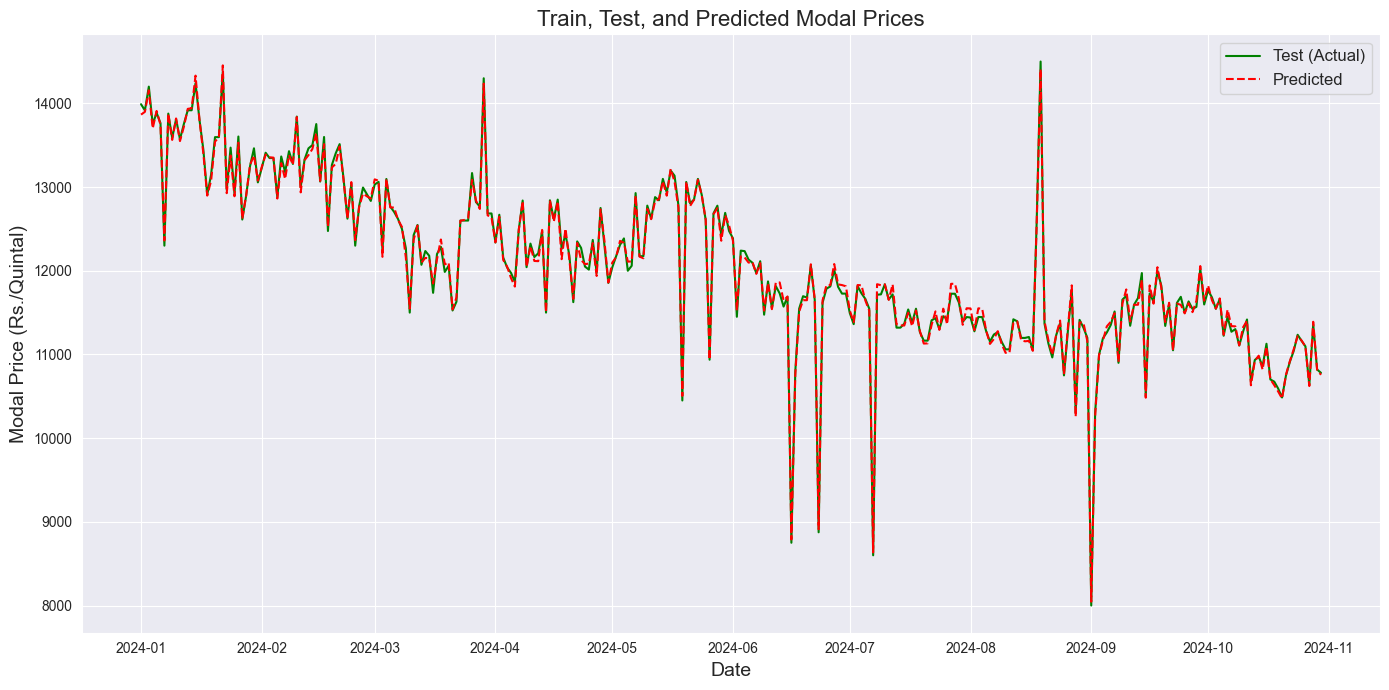

Metrics:
Mean Absolute Error (MAE): 39.1273
Symmetric Mean Absolute Percentage Error (SMAPE): 0.3250
Median Absolute Percentage Error (MDAPE): 0.2559
Geometric Mean Relative Absolute Error (GMRAE): 0.0441


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Assuming `df` contains your data, and it is already prepared with features and target column
# Define train and test data
train_data = df.loc[:'2023-12-31']
test_data = df.loc['2024-01-01':'2024-10-31']

# Extract features and target
feature_columns = [col for col in df.columns if col != 'Modal Price (Rs./Quintal)']
X_train = train_data[feature_columns]
y_train = train_data['Modal Price (Rs./Quintal)']
X_test = test_data[feature_columns]
y_test = test_data['Modal Price (Rs./Quintal)']
model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Add predictions to test data
test_data = test_data.copy()  # Avoid SettingWithCopyWarning
test_data['Predicted'] = y_pred

# Plot
plt.figure(figsize=(14, 7))


# Plot test data (actual values)
plt.plot(test_data.index, test_data['Modal Price (Rs./Quintal)'], label='Test (Actual)', color='green')

# Plot predictions
plt.plot(test_data.index, test_data['Predicted'], label='Predicted', color='red', linestyle='--')

# Add title and labels
plt.title("Train, Test, and Predicted Modal Prices", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Modal Price (Rs./Quintal)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

# Metrics Calculation
def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    non_zero_mask = (np.abs(y_true) + np.abs(y_pred)) > 0  # Avoid division by zero
    return 100 * np.mean(2 * np.abs(y_pred[non_zero_mask] - y_true[non_zero_mask]) /
                         (np.abs(y_true[non_zero_mask]) + np.abs(y_pred[non_zero_mask])))

def mdape(y_true, y_pred):
    """Median Absolute Percentage Error"""
    non_zero_mask = y_true != 0  # Avoid division by zero
    return 100 * np.median(np.abs((y_pred[non_zero_mask] - y_true[non_zero_mask]) / y_true[non_zero_mask]))

def gmrae(y_true, y_pred):
    """Geometric Mean Relative Absolute Error"""
    numerator = np.abs(y_true - y_pred)
    denominator = np.abs(y_true - np.mean(y_true))
    ratio = numerator / (denominator + 1e-10)  # Avoid division by zero
    return np.exp(np.mean(np.log(ratio + 1e-10)))

mae = mean_absolute_error(y_test, y_pred)
smape_val = smape(y_test.values, y_pred)
mdape_val = mdape(y_test.values, y_pred)
gmrae_val = gmrae(y_test.values, y_pred)

# Print metrics
print("Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape_val:.4f}")
print(f"Median Absolute Percentage Error (MDAPE): {mdape_val:.4f}")
print(f"Geometric Mean Relative Absolute Error (GMRAE): {gmrae_val:.4f}")
